In [1]:
import tensorflow as tf
from tensorflow.keras.applications import ResNet50, DenseNet201, VGG16, VGG19, InceptionV3
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
from tensorflow.keras.initializers import HeUniform

import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Activation, BatchNormalization
from tensorflow.keras.models import Model

from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import precision_recall_curve, auc, roc_curve

import sklearn
from sklearn.model_selection import train_test_split
import os
import numpy as np
import os
import shutil
import random
from matplotlib import pyplot as plt
import matplotlib

print("\nLibraries\n-----------------------------")
print(f"Tensorflow: {tf.__version__}")
print(f"Scikit Learn: {sklearn.__version__}")
print(f"Numpy: {np.__version__}")
print(f"Matplotlib: {matplotlib.__version__}")


Libraries
-----------------------------
Tensorflow: 2.12.0
Scikit Learn: 1.2.1
Numpy: 1.22.1
Matplotlib: 3.7.0


In [2]:
def count_files_in_directory(directory_path):
    total_files = 0

    for root, _, files in os.walk(directory_path):
        total_files += len(files)

    return total_files

In [3]:
def create_test_set(source_dir, test_dir, class_names, test_percent):
    os.makedirs(test_dir, exist_ok = True)
    
    for class_name in class_names:
        class_source_dir = os.path.join(source_dir, class_name)
        class_test_dir = os.path.join(test_dir, class_name)
        os.makedirs(class_test_dir, exist_ok = True)
        
        images = os.listdir(class_source_dir)
        num_images = len(images)
        num_test_images = int(test_percent * num_images)
        
        test_indices = random.sample(range(num_images), num_test_images)
        
        for index in test_indices:
            image_name = images[index]
            source_path = os.path.join(class_source_dir, image_name)
            target_path = os.path.join(class_test_dir, image_name)
            shutil.move(source_path, target_path)

In [4]:
# Define image dimensions and other parameters
img_height, img_width = 80, 400
num_classes = 3

data_dir = "./DS2/Train"
class_names = os.listdir(data_dir)

# test set
source_data_dir = "./DS2/Train"
test_data_dir = "./DS2/Testset"
valid_data_dir = "./DS2/Validset"
class_names = os.listdir(source_data_dir)

first_execution = True

if first_execution:
    create_test_set(source_data_dir, test_data_dir, class_names, 0.3)
    create_test_set(source_data_dir, valid_data_dir, class_names, 0.2)

In [5]:
datagen = ImageDataGenerator(
    rotation_range = 40,
    width_shift_range = 0.2,
    height_shift_range = 0.2,
    shear_range = 0.2,
    zoom_range = 0.2,
    horizontal_flip = True,
    vertical_flip = True,
    rescale = 1.0 / 255.00,
    preprocessing_function = tf.keras.applications.densenet.preprocess_input
)

data_generator = datagen.flow_from_directory(
    data_dir,
    target_size = (img_height, img_width),
    batch_size = 32,
    class_mode = 'categorical',
    shuffle = True,
    classes = class_names
)

validation_datagen = ImageDataGenerator(rescale=1./255)

validation_generator = validation_datagen.flow_from_directory(
        "./DS2/Validset",
        target_size = (img_height, img_width),
        batch_size = 32,
        class_mode = 'categorical',
        shuffle = True,
        classes = class_names
)

Found 370 images belonging to 3 classes.
Found 130 images belonging to 3 classes.


In [6]:
base_model = DenseNet201(
    weights = "imagenet",
    include_top = False,
    input_shape = (img_height, img_width, 3)
)

# freeze already trained layers for transfer learning
for layer in base_model.layers:
    layer.trainable = False

x = base_model.output
x = Flatten()(x)
x = Dense(128, activation = 'relu', kernel_initializer = 'uniform')(x)
predictions = Dense(num_classes, activation = 'softmax')(x)

model = Model(inputs = base_model.input, outputs = predictions)

In [7]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 80, 400, 3)  0           []                               
                                ]                                                                 
                                                                                                  
 zero_padding2d (ZeroPadding2D)  (None, 86, 406, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1/conv (Conv2D)            (None, 40, 200, 64)  9408        ['zero_padding2d[0][0]']         
                                                                                                  
 conv1/bn (BatchNormalization)  (None, 40, 200, 64)  256         ['conv1/conv[0][0]']         

 n)                             )                                                                 
                                                                                                  
 conv2_block4_1_conv (Conv2D)   (None, 20, 100, 128  20480       ['conv2_block4_0_relu[0][0]']    
                                )                                                                 
                                                                                                  
 conv2_block4_1_bn (BatchNormal  (None, 20, 100, 128  512        ['conv2_block4_1_conv[0][0]']    
 ization)                       )                                                                 
                                                                                                  
 conv2_block4_1_relu (Activatio  (None, 20, 100, 128  0          ['conv2_block4_1_bn[0][0]']      
 n)                             )                                                                 
          

 conv3_block1_concat (Concatena  (None, 10, 50, 160)  0          ['pool2_pool[0][0]',             
 te)                                                              'conv3_block1_2_conv[0][0]']    
                                                                                                  
 conv3_block2_0_bn (BatchNormal  (None, 10, 50, 160)  640        ['conv3_block1_concat[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv3_block2_0_relu (Activatio  (None, 10, 50, 160)  0          ['conv3_block2_0_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv3_block2_1_conv (Conv2D)   (None, 10, 50, 128)  20480       ['conv3_block2_0_relu[0][0]']    
          

 n)                                                                                               
                                                                                                  
 conv3_block6_1_conv (Conv2D)   (None, 10, 50, 128)  36864       ['conv3_block6_0_relu[0][0]']    
                                                                                                  
 conv3_block6_1_bn (BatchNormal  (None, 10, 50, 128)  512        ['conv3_block6_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv3_block6_1_relu (Activatio  (None, 10, 50, 128)  0          ['conv3_block6_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv3_blo

 conv3_block10_1_relu (Activati  (None, 10, 50, 128)  0          ['conv3_block10_1_bn[0][0]']     
 on)                                                                                              
                                                                                                  
 conv3_block10_2_conv (Conv2D)  (None, 10, 50, 32)   36864       ['conv3_block10_1_relu[0][0]']   
                                                                                                  
 conv3_block10_concat (Concaten  (None, 10, 50, 448)  0          ['conv3_block9_concat[0][0]',    
 ate)                                                             'conv3_block10_2_conv[0][0]']   
                                                                                                  
 conv3_block11_0_bn (BatchNorma  (None, 10, 50, 448)  1792       ['conv3_block10_concat[0][0]']   
 lization)                                                                                        
          

                                                                                                  
 conv4_block2_1_relu (Activatio  (None, 5, 25, 128)  0           ['conv4_block2_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv4_block2_2_conv (Conv2D)   (None, 5, 25, 32)    36864       ['conv4_block2_1_relu[0][0]']    
                                                                                                  
 conv4_block2_concat (Concatena  (None, 5, 25, 320)  0           ['conv4_block1_concat[0][0]',    
 te)                                                              'conv4_block2_2_conv[0][0]']    
                                                                                                  
 conv4_block3_0_bn (BatchNormal  (None, 5, 25, 320)  1280        ['conv4_block2_concat[0][0]']    
 ization) 

 te)                                                              'conv4_block6_2_conv[0][0]']    
                                                                                                  
 conv4_block7_0_bn (BatchNormal  (None, 5, 25, 448)  1792        ['conv4_block6_concat[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv4_block7_0_relu (Activatio  (None, 5, 25, 448)  0           ['conv4_block7_0_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv4_block7_1_conv (Conv2D)   (None, 5, 25, 128)   57344       ['conv4_block7_0_relu[0][0]']    
                                                                                                  
 conv4_blo

                                                                                                  
 conv4_block11_1_conv (Conv2D)  (None, 5, 25, 128)   73728       ['conv4_block11_0_relu[0][0]']   
                                                                                                  
 conv4_block11_1_bn (BatchNorma  (None, 5, 25, 128)  512         ['conv4_block11_1_conv[0][0]']   
 lization)                                                                                        
                                                                                                  
 conv4_block11_1_relu (Activati  (None, 5, 25, 128)  0           ['conv4_block11_1_bn[0][0]']     
 on)                                                                                              
                                                                                                  
 conv4_block11_2_conv (Conv2D)  (None, 5, 25, 32)    36864       ['conv4_block11_1_relu[0][0]']   
          

 on)                                                                                              
                                                                                                  
 conv4_block15_2_conv (Conv2D)  (None, 5, 25, 32)    36864       ['conv4_block15_1_relu[0][0]']   
                                                                                                  
 conv4_block15_concat (Concaten  (None, 5, 25, 736)  0           ['conv4_block14_concat[0][0]',   
 ate)                                                             'conv4_block15_2_conv[0][0]']   
                                                                                                  
 conv4_block16_0_bn (BatchNorma  (None, 5, 25, 736)  2944        ['conv4_block15_concat[0][0]']   
 lization)                                                                                        
                                                                                                  
 conv4_blo

 conv4_block20_0_bn (BatchNorma  (None, 5, 25, 864)  3456        ['conv4_block19_concat[0][0]']   
 lization)                                                                                        
                                                                                                  
 conv4_block20_0_relu (Activati  (None, 5, 25, 864)  0           ['conv4_block20_0_bn[0][0]']     
 on)                                                                                              
                                                                                                  
 conv4_block20_1_conv (Conv2D)  (None, 5, 25, 128)   110592      ['conv4_block20_0_relu[0][0]']   
                                                                                                  
 conv4_block20_1_bn (BatchNorma  (None, 5, 25, 128)  512         ['conv4_block20_1_conv[0][0]']   
 lization)                                                                                        
          

                                                                                                  
 conv4_block24_1_bn (BatchNorma  (None, 5, 25, 128)  512         ['conv4_block24_1_conv[0][0]']   
 lization)                                                                                        
                                                                                                  
 conv4_block24_1_relu (Activati  (None, 5, 25, 128)  0           ['conv4_block24_1_bn[0][0]']     
 on)                                                                                              
                                                                                                  
 conv4_block24_2_conv (Conv2D)  (None, 5, 25, 32)    36864       ['conv4_block24_1_relu[0][0]']   
                                                                                                  
 conv4_block24_concat (Concaten  (None, 5, 25, 1024)  0          ['conv4_block23_concat[0][0]',   
 ate)     

 conv4_block28_2_conv (Conv2D)  (None, 5, 25, 32)    36864       ['conv4_block28_1_relu[0][0]']   
                                                                                                  
 conv4_block28_concat (Concaten  (None, 5, 25, 1152)  0          ['conv4_block27_concat[0][0]',   
 ate)                                                             'conv4_block28_2_conv[0][0]']   
                                                                                                  
 conv4_block29_0_bn (BatchNorma  (None, 5, 25, 1152)  4608       ['conv4_block28_concat[0][0]']   
 lization)                                                                                        
                                                                                                  
 conv4_block29_0_relu (Activati  (None, 5, 25, 1152)  0          ['conv4_block29_0_bn[0][0]']     
 on)                                                                                              
          

                                                                                                  
 conv4_block33_0_relu (Activati  (None, 5, 25, 1280)  0          ['conv4_block33_0_bn[0][0]']     
 on)                                                                                              
                                                                                                  
 conv4_block33_1_conv (Conv2D)  (None, 5, 25, 128)   163840      ['conv4_block33_0_relu[0][0]']   
                                                                                                  
 conv4_block33_1_bn (BatchNorma  (None, 5, 25, 128)  512         ['conv4_block33_1_conv[0][0]']   
 lization)                                                                                        
                                                                                                  
 conv4_block33_1_relu (Activati  (None, 5, 25, 128)  0           ['conv4_block33_1_bn[0][0]']     
 on)      

 lization)                                                                                        
                                                                                                  
 conv4_block37_1_relu (Activati  (None, 5, 25, 128)  0           ['conv4_block37_1_bn[0][0]']     
 on)                                                                                              
                                                                                                  
 conv4_block37_2_conv (Conv2D)  (None, 5, 25, 32)    36864       ['conv4_block37_1_relu[0][0]']   
                                                                                                  
 conv4_block37_concat (Concaten  (None, 5, 25, 1440)  0          ['conv4_block36_concat[0][0]',   
 ate)                                                             'conv4_block37_2_conv[0][0]']   
                                                                                                  
 conv4_blo

 conv4_block41_concat (Concaten  (None, 5, 25, 1568)  0          ['conv4_block40_concat[0][0]',   
 ate)                                                             'conv4_block41_2_conv[0][0]']   
                                                                                                  
 conv4_block42_0_bn (BatchNorma  (None, 5, 25, 1568)  6272       ['conv4_block41_concat[0][0]']   
 lization)                                                                                        
                                                                                                  
 conv4_block42_0_relu (Activati  (None, 5, 25, 1568)  0          ['conv4_block42_0_bn[0][0]']     
 on)                                                                                              
                                                                                                  
 conv4_block42_1_conv (Conv2D)  (None, 5, 25, 128)   200704      ['conv4_block42_0_relu[0][0]']   
          

 on)                                                                                              
                                                                                                  
 conv4_block46_1_conv (Conv2D)  (None, 5, 25, 128)   217088      ['conv4_block46_0_relu[0][0]']   
                                                                                                  
 conv4_block46_1_bn (BatchNorma  (None, 5, 25, 128)  512         ['conv4_block46_1_conv[0][0]']   
 lization)                                                                                        
                                                                                                  
 conv4_block46_1_relu (Activati  (None, 5, 25, 128)  0           ['conv4_block46_1_bn[0][0]']     
 on)                                                                                              
                                                                                                  
 conv4_blo

 conv5_block2_0_relu (Activatio  (None, 2, 12, 928)  0           ['conv5_block2_0_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv5_block2_1_conv (Conv2D)   (None, 2, 12, 128)   118784      ['conv5_block2_0_relu[0][0]']    
                                                                                                  
 conv5_block2_1_bn (BatchNormal  (None, 2, 12, 128)  512         ['conv5_block2_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv5_block2_1_relu (Activatio  (None, 2, 12, 128)  0           ['conv5_block2_1_bn[0][0]']      
 n)                                                                                               
          

                                                                                                  
 conv5_block6_1_relu (Activatio  (None, 2, 12, 128)  0           ['conv5_block6_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv5_block6_2_conv (Conv2D)   (None, 2, 12, 32)    36864       ['conv5_block6_1_relu[0][0]']    
                                                                                                  
 conv5_block6_concat (Concatena  (None, 2, 12, 1088)  0          ['conv5_block5_concat[0][0]',    
 te)                                                              'conv5_block6_2_conv[0][0]']    
                                                                                                  
 conv5_block7_0_bn (BatchNormal  (None, 2, 12, 1088)  4352       ['conv5_block6_concat[0][0]']    
 ization) 

 ate)                                                             'conv5_block10_2_conv[0][0]']   
                                                                                                  
 conv5_block11_0_bn (BatchNorma  (None, 2, 12, 1216)  4864       ['conv5_block10_concat[0][0]']   
 lization)                                                                                        
                                                                                                  
 conv5_block11_0_relu (Activati  (None, 2, 12, 1216)  0          ['conv5_block11_0_bn[0][0]']     
 on)                                                                                              
                                                                                                  
 conv5_block11_1_conv (Conv2D)  (None, 2, 12, 128)   155648      ['conv5_block11_0_relu[0][0]']   
                                                                                                  
 conv5_blo

                                                                                                  
 conv5_block15_1_conv (Conv2D)  (None, 2, 12, 128)   172032      ['conv5_block15_0_relu[0][0]']   
                                                                                                  
 conv5_block15_1_bn (BatchNorma  (None, 2, 12, 128)  512         ['conv5_block15_1_conv[0][0]']   
 lization)                                                                                        
                                                                                                  
 conv5_block15_1_relu (Activati  (None, 2, 12, 128)  0           ['conv5_block15_1_bn[0][0]']     
 on)                                                                                              
                                                                                                  
 conv5_block15_2_conv (Conv2D)  (None, 2, 12, 32)    36864       ['conv5_block15_1_relu[0][0]']   
          

 on)                                                                                              
                                                                                                  
 conv5_block19_2_conv (Conv2D)  (None, 2, 12, 32)    36864       ['conv5_block19_1_relu[0][0]']   
                                                                                                  
 conv5_block19_concat (Concaten  (None, 2, 12, 1504)  0          ['conv5_block18_concat[0][0]',   
 ate)                                                             'conv5_block19_2_conv[0][0]']   
                                                                                                  
 conv5_block20_0_bn (BatchNorma  (None, 2, 12, 1504)  6016       ['conv5_block19_concat[0][0]']   
 lization)                                                                                        
                                                                                                  
 conv5_blo

 conv5_block24_0_bn (BatchNorma  (None, 2, 12, 1632)  6528       ['conv5_block23_concat[0][0]']   
 lization)                                                                                        
                                                                                                  
 conv5_block24_0_relu (Activati  (None, 2, 12, 1632)  0          ['conv5_block24_0_bn[0][0]']     
 on)                                                                                              
                                                                                                  
 conv5_block24_1_conv (Conv2D)  (None, 2, 12, 128)   208896      ['conv5_block24_0_relu[0][0]']   
                                                                                                  
 conv5_block24_1_bn (BatchNorma  (None, 2, 12, 128)  512         ['conv5_block24_1_conv[0][0]']   
 lization)                                                                                        
          

                                                                                                  
 conv5_block28_1_bn (BatchNorma  (None, 2, 12, 128)  512         ['conv5_block28_1_conv[0][0]']   
 lization)                                                                                        
                                                                                                  
 conv5_block28_1_relu (Activati  (None, 2, 12, 128)  0           ['conv5_block28_1_bn[0][0]']     
 on)                                                                                              
                                                                                                  
 conv5_block28_2_conv (Conv2D)  (None, 2, 12, 32)    36864       ['conv5_block28_1_relu[0][0]']   
                                                                                                  
 conv5_block28_concat (Concaten  (None, 2, 12, 1792)  0          ['conv5_block27_concat[0][0]',   
 ate)     

 conv5_block32_2_conv (Conv2D)  (None, 2, 12, 32)    36864       ['conv5_block32_1_relu[0][0]']   
                                                                                                  
 conv5_block32_concat (Concaten  (None, 2, 12, 1920)  0          ['conv5_block31_concat[0][0]',   
 ate)                                                             'conv5_block32_2_conv[0][0]']   
                                                                                                  
 bn (BatchNormalization)        (None, 2, 12, 1920)  7680        ['conv5_block32_concat[0][0]']   
                                                                                                  
 relu (Activation)              (None, 2, 12, 1920)  0           ['bn[0][0]']                     
                                                                                                  
 flatten (Flatten)              (None, 46080)        0           ['relu[0][0]']                   
          

In [8]:
model.compile(optimizer = SGD(learning_rate = 0.001, momentum = 0.9),
              loss = 'categorical_crossentropy',
              metrics = ['accuracy'])

history = model.fit(data_generator, epochs = 100,
                    validation_data = validation_generator, verbose = 0)

### Please note that the following curves a clear example of overfitting, this is seen by a clear divergence in training (blue) and validation loss (organge curve). Curves should ideally show convergence while a small gap should exist between the two curves to wards the end of the training cycle

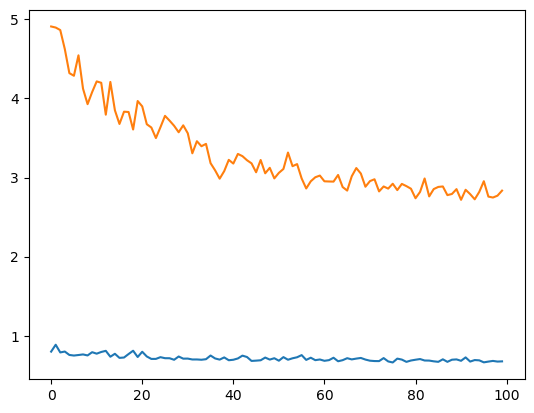

In [9]:
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.show()

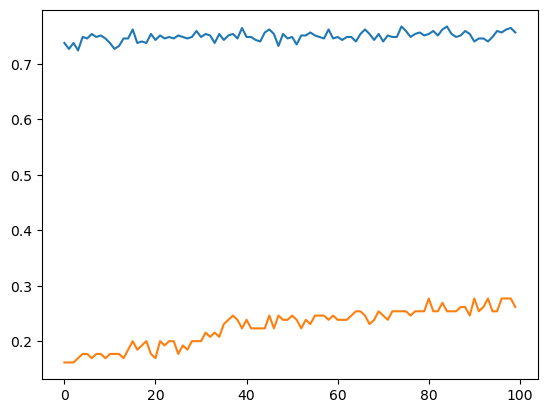

In [10]:
plt.plot(history.history["accuracy"])
plt.plot(history.history["val_accuracy"])
plt.show()

In [11]:
test_datagen = ImageDataGenerator(
    rescale=1./255
)
test_generator = test_datagen.flow_from_directory(
    test_data_dir,
    target_size = (img_height, img_width),
    class_mode = 'categorical',
    batch_size = count_files_in_directory(test_data_dir),
    shuffle = False,
    classes = class_names
)

Found 194 images belonging to 3 classes.


In [12]:
real_labels = []
test_probs = []
test_labels = []
test_errors = []
batch_images, batch_labels = next(test_generator)

for individual_image in range(batch_images.shape[0]):
    single_image_array = batch_images[individual_image]
    single_image_label = batch_labels[individual_image]
    
    test_prob = model.predict(np.expand_dims(single_image_array, axis=0), verbose = 0)
    test_pred = np.argmax(test_prob)
    test_error = np.sqrt(np.mean((test_prob - single_image_label) ** 2))
    
    
    real_labels.append(single_image_label)
    test_probs.append(test_prob[0, test_pred])
    test_labels.append(test_pred)
    test_errors.append(test_error)

test_probs = np.array(test_probs).reshape(-1)
test_labels = np.array(test_labels).reshape(-1)
test_errors = np.array(test_errors).reshape(-1)

In [13]:
class_labels = []
for array in real_labels:
    class_label = np.argmax(array)
    class_labels.append(class_label)
real_labels = class_labels
indices0 = [index for index, value in enumerate(real_labels) if value == 0]
indices1 = [index for index, value in enumerate(real_labels) if value == 1]
indices2 = [index for index, value in enumerate(real_labels) if value == 2]

### Please note through both loss values and the confusion matrix that the algorithm has a high misclassification rate, this is a clear sign of an algorithm that is not working. This is due to the large imbalance between the classes in the dataset

In [14]:
print(f"Test Tooth Score Loss {np.mean(test_errors[indices1]) * 100:.2f}%")
print(f"Test Cut Mark Loss {np.mean(test_errors[indices0]) * 100:.2f}%")
print(f"Test Trampling Mark Loss {np.mean(test_errors[indices2]) * 100:.2f}%")
print(f"Overall Loss {np.mean(test_errors) * 100:.2f}%")

Test Tooth Score Loss 65.97%
Test Cut Mark Loss 60.25%
Test Trampling Mark Loss 77.71%
Overall Loss 62.75%


In [15]:
print(classification_report(real_labels, test_labels))
print(confusion_matrix(real_labels, test_labels))

              precision    recall  f1-score   support

           0       0.38      0.17      0.24       146
           1       0.03      0.13      0.05        30
           2       0.00      0.00      0.00        18

    accuracy                           0.15       194
   macro avg       0.14      0.10      0.10       194
weighted avg       0.29      0.15      0.19       194

[[ 25 118   3]
 [ 26   4   0]
 [ 15   3   0]]


In [16]:
return_files = True

if return_files:
    source_folders = ["./DS2/Testset", "./DS2/Validset"]
    destination_folder = "./DS2/Train"

    for source_folder in source_folders:
        source_path = os.path.join(source_folder, "CutMark")
        destination_path = os.path.join(destination_folder, "CutMark")

        # Move files from source subfolder to destination subfolder
        for filename in os.listdir(source_path):
            source_file = os.path.join(source_path, filename)
            destination_file = os.path.join(destination_path, filename)
            shutil.move(source_file, destination_file)

        source_path = os.path.join(source_folder, "Score")
        destination_path = os.path.join(destination_folder, "Score")

        # Move files from source subfolder to destination subfolder
        for filename in os.listdir(source_path):
            source_file = os.path.join(source_path, filename)
            destination_file = os.path.join(destination_path, filename)
            shutil.move(source_file, destination_file)

        source_path = os.path.join(source_folder, "Trampling")
        destination_path = os.path.join(destination_folder, "Trampling")

        # Move files from source subfolder to destination subfolder
        for filename in os.listdir(source_path):
            source_file = os.path.join(source_path, filename)
            destination_file = os.path.join(destination_path, filename)
            shutil.move(source_file, destination_file)

    print("Files moved successfully.")

Files moved successfully.
